# Regression on RBS sequences - Escherichia coli - Predict TIR

This notebook shows the regression of RBS sequences.

There are several parts of the implementation. 

- Reading the dataset
- Embedding
    - Label
    - One-hot embedding
    - K-mer 
    - PMW (to be added)
    - Unsupervised (to be added)
- Kernels
    - Spectrum
    - Mixed Spectrum
    - Weighted Degree
    - Weighted Degree with Shifting
- Evaluate
    - RMSE score
    - Plot

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels_pairwise import spectrum_kernel_pw, sum_spectrum_kernel_pw, sum_onehot_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading the Dataset

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/RBS_list.xlsx'

df = pd.read_excel(Path, sheet_name='Unique RBS')
df.columns = ['A', 'B', 'C', 'D', 'E', 'F']
df.head()

,A,B,C,D,E,F
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,TTAAGTAAGCGGGGAAAATA,57706.0,NaN,AAGTAAGCGGGGA,NaN
1,ACGATCTTAAGTAGACGCGGAAAATAATG,TTAAGTAGACGCGGAAAATA,613.0,NaN,AAGTAGACGCGGA,NaN
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,TTAAGTAAGCGCGGAAAATA,5313.0,NaN,AAGTAAGCGCGGA,NaN
3,ACGATCTTAAGTAAACGAGGAAAATAATG,TTAAGTAAACGAGGAAAATA,19594.0,NaN,AAGTAAACGAGGA,NaN
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,TTAAGTAGGCGAGGAAAATA,33626.0,NaN,AAGTAGGCGAGGA,NaN


In [4]:
Log_flag = False # indicates whether take log label
Norm_method = 'minmax' # indicates how to normalize label (one of 'mean', 'minmax', None)

In [5]:
df = df.drop_duplicates(subset =['B', 'C'])

df = df[['B', 'C']].dropna()

# take log FC -- possiblely provide Gaussain distribution?
if Log_flag:
    df['C'] = np.log(df['C'])

if Norm_method == 'mean':
    # mean normalization
    df['C'] = (df['C'] - df['C'].mean())/df['C'].std()
elif Norm_method == 'minmax':
    # min-max normalization 
    df['C'] = (df['C'] - df['C'].min())/(df['C'].max() - df['C'].min())
else:
    assert Norm_method == None


data = np.asarray(df[['B', 'C']])
data.shape

(113, 2)

(array([59., 18., 14.,  5.,  4.,  1.,  5.,  3.,  1.,  3.]),
 array([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001,
        0.7000000000000001, 0.8, 0.9, 1.0], dtype=object),
 <a list of 10 Patch objects>)

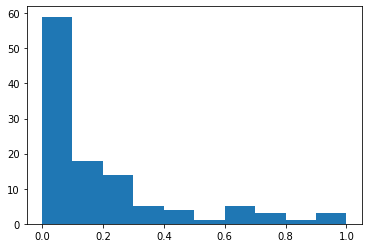

In [6]:
plt.hist(data[:,1])

## Regression

- Kernel Ridge Regression
- Gaussian Process Regression


In [7]:
# indicates whether cross validation (KFOLD)
cross_val_flag = False 

# indicates whether plot predict_label vs. true label
plot_flag = True 

# string kernel list 
# kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw]
kernels = [sum_onehot_spectrum_kernel_pw, sum_spectrum_kernel_pw, spectrum_kernel_pw]

# name dictionaries
regression_name = {KernelRidge: 'KR',
                  GaussianProcessRegressor: 'GPR'}
embedding_name = ['onehot', 'kmer', 'label']
kernel_name = {
               spectrum_kernel_pw: 'spec',
               sum_spectrum_kernel_pw: 'sspec',
               sum_onehot_spectrum_kernel_pw: 'sospec',
               mixed_spectrum_kernel_pw: 'mspec',
               WD_kernel_pw: 'WD',
               WD_shift_kernel_pw: 'WDshift'}

train_scores = {}
test_scores = {}

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function sum_onehot_spectrum_kernel_pw at 0x7f0daa6b6400>,
            kernel_params=None)
Train RMSE:  0.16743576816517025
Test RMSE:  0.26972324638457534

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function sum_spectrum_kernel_pw at 0x7f0daa6b6378>,
            kernel_params=None)
Train RMSE:  0.1630098834226349
Test RMSE:  0.2687576171102484

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function spectrum_kernel_pw at 0x7f0daa6b62f0>,
            kernel_params=None)
Train RMSE:  0.1647947309670132
Test RMSE:  0.2710794157165622

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function sum_onehot_spectrum_kernel_pw at 0x7f0daa6b6400>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', 

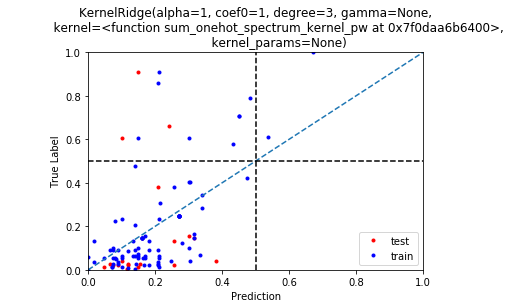

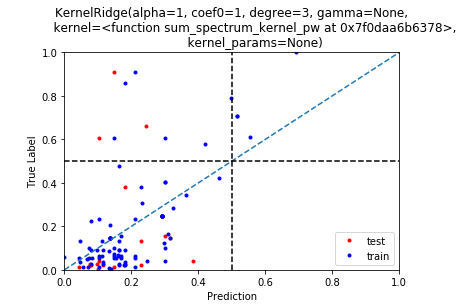

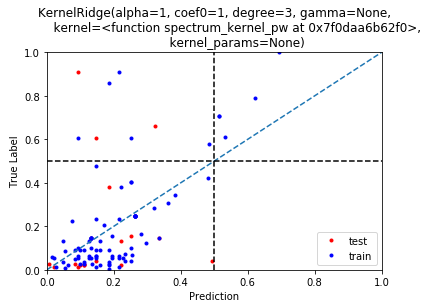

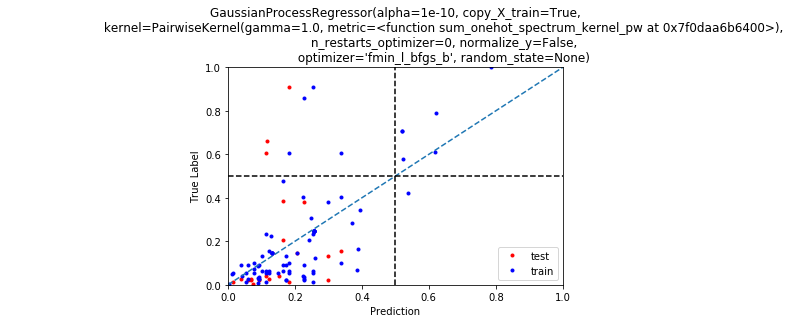

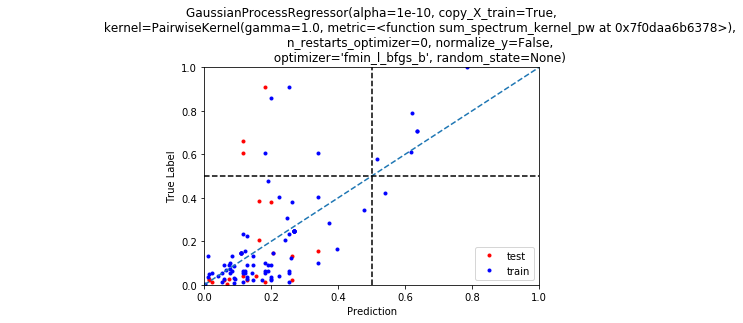

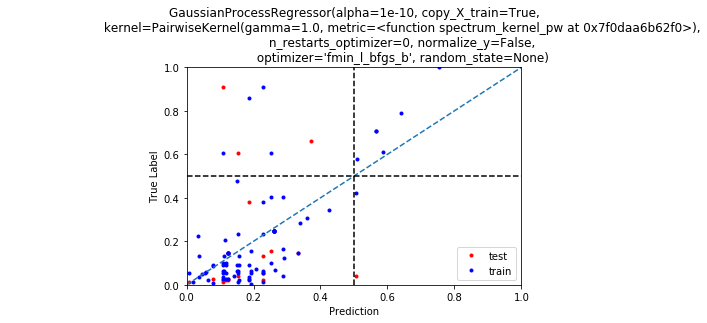

In [8]:
def run_regression(model, kernel, embedding):
    if model == KernelRidge:
        reg = Regression(model(kernel = kernel), data, embedding)
    elif model == GaussianProcessRegressor:
        reg = Regression(model(kernel = PairwiseKernel(metric = kernel)), data, embedding)
    reg.train()
    train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = plot_flag)
    key = regression_name[model] + '_' + kernel_name[kernel] + '_' + embedding
    train_scores[key] = train_score
    test_scores[key] = test_score
    print()

for model in [KernelRidge, GaussianProcessRegressor]:
    for kernel in kernels:
        run_regression(model, kernel, 'label')

### Kernel Ridge Regression 

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.1701305705775561
Test RMSE:  0.24300914629630313


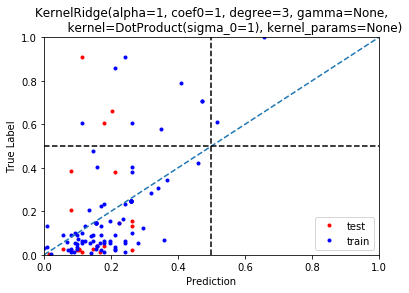

In [9]:
# Baseline: onehot embedding with DotProduct kernel

reg = Regression(KernelRidge(kernel = DotProduct()), data, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['KR_onehot_DP'] = train_score
test_scores['KR_onehot_DP'] = test_score

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.2076589389937923
Test RMSE:  0.246016395436759


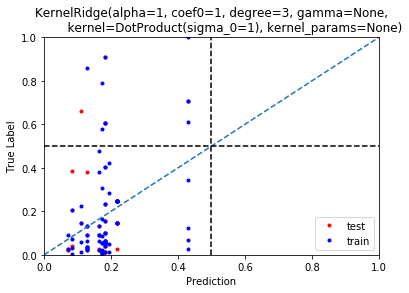

In [10]:
# kmer embedding with DotProduct kernel (l = 3)

reg = Regression(KernelRidge(kernel = DotProduct()), data, 'kmer')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['KR_kmer_DP'] = train_score
test_scores['KR_kmer_DP'] = test_score

### Gaussian Process Regression

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train RMSE:  0.16651125304073472
Test RMSE:  0.24812760201744538


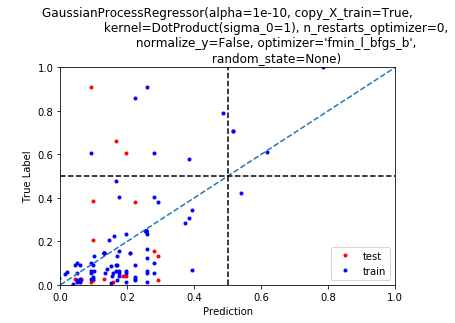

In [11]:
# # baseline: onehot embedding with DotProduct Kernel 
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['GPR_onehot_DP'] = train_score
test_scores['GPR_onehot_DP'] = test_score

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)
Train RMSE:  0.20755497447265103
Test RMSE:  0.2457490692348374


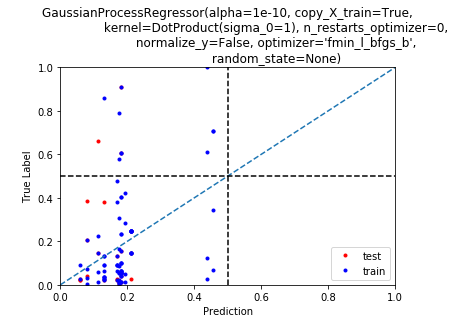

In [12]:
# kmer embedding (l = 3)
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'kmer')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores['GPR_kmer_DP'] = train_score
test_scores['GPR_kmer_DP'] = test_score

Text(0.5, 1.0, 'Train Scores')

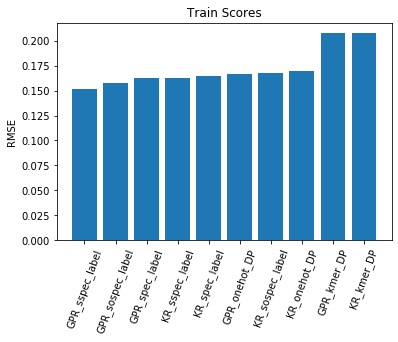

In [13]:
sorted_train_scores = sorted(train_scores.items(), key=lambda kv: kv[1])

import collections

sorted_train_scores = collections.OrderedDict(sorted_train_scores)

plt.bar(range(len(sorted_train_scores)), list(sorted_train_scores.values()), align='center')
plt.xticks(range(len(sorted_train_scores)), list(sorted_train_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Train Scores')

Text(0.5, 1.0, 'Test Scores')

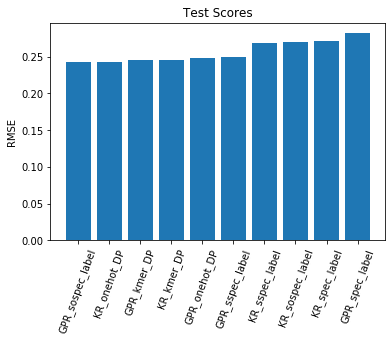

In [14]:
sorted_test_scores = sorted(test_scores.items(), key=lambda kv: kv[1])

import collections

sorted_test_scores = collections.OrderedDict(sorted_test_scores)

plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Test Scores')